In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import networkx as nx
%matplotlib inline

In [2]:
INPUT_FOLDER = 'geolife-trajectories/processed_data/'
FILE_NAME = INPUT_FOLDER + 'BeijingWalkingAreas.csv'

if not os.path.exists(FILE_NAME):
    list_df = []
    for file in os.listdir(INPUT_FOLDER):
        df = pd.read_csv(INPUT_FOLDER + file)
        list_df.append(df)
    df = pd.concat(list_df, ignore_index=True)
    df.drop('Unnamed: 0', inplace=True, axis=1)
    df['datetime'] = pd.to_datetime(df['datetime'], errors='ignore')
    # Beijing
    latMinB = 39.64
    latMaxB = 40.51
    longMinB = 115.76
    longMaxB = 116.88
    df = df[(df.lat.between(latMinB, latMaxB)) & (df.long.between(longMinB, longMaxB))]
    df = df[df['labels'] == 'walk']
    df = df[['lat', 'long', 'datetime', 'trajectory_id']]
    df.reset_index(drop=True, inplace=True)
    df.to_csv(FILE_NAME, index=False)

df = pd.read_csv(FILE_NAME)
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])

# drop short trajectories
traj_len = 10
long_traj = df['trajectory_id'].value_counts()
long_traj = long_traj.where(long_traj.values > traj_len).dropna().keys()
df = df.loc[df['trajectory_id'].isin(long_traj)]
df.head()

,lat,long,datetime,trajectory_id
0,39.900008,116.412534,2008-06-17 10:53:07,20080617094444
1,39.900011,116.412560,2008-06-17 10:53:08,20080617094444
2,39.900015,116.412581,2008-06-17 10:53:09,20080617094444
3,39.900021,116.412616,2008-06-17 10:53:11,20080617094444
4,39.900030,116.412639,2008-06-17 10:53:12,20080617094444


2009-08-07 15:49:03 2008-11-05 11:33:07 2007-04-14 00:56:28 2011-12-31 15:18:07


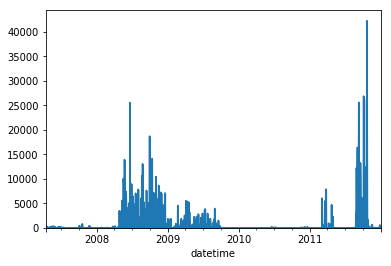

In [3]:
# get some datetime statistics: avg, med, min, max
def func_datetime(series, func=np.average):
    dt_min = series.min()
    deltas = [(x-dt_min).total_seconds() for x in series]
    return dt_min + np.timedelta64(int(func(deltas)), 's')

print(func_datetime(df['datetime']), func_datetime(df['datetime'], func=np.median), df['datetime'].min(), df['datetime'].max())
df.set_index('datetime').resample('D').count().lat.plot(kind='area')

In [4]:
# compress data to have unit time intervals
# for now I've decided to use one minute interval
def compress(df, verbose=False):
    list_df = []
    iter_count = 0
    if verbose:
        print('Amount of iterations needed: ' + str(len(df['trajectory_id'].unique())))
    for t_id in df['trajectory_id'].unique():
        iter_count += 1
        single_trajectory = df.loc[df['trajectory_id']==t_id]
        single_trajectory['datetime'] = pd.to_datetime(single_trajectory['datetime'].values.astype('<M8[m]'))
        list_single_df = []
        for st_dt in single_trajectory['datetime'].unique():
            avg_values = single_trajectory[['lat', 'long']].loc[single_trajectory['datetime'].values==st_dt].mean().values.tolist() + [st_dt, t_id]
            list_single_df.append(pd.DataFrame(np.reshape(avg_values, (1, len(avg_values))), columns=df.columns.values))
        list_df.append(pd.concat(list_single_df, ignore_index=True))
        if verbose:
            print('Iteration ' + str(iter_count) + ': Added ' + str(list_df[-1].count()[0]) + ' rows\n')
    return pd.concat(list_df, ignore_index=True)

df_compressed = compress(df)
df_compressed['datetime'] = pd.DatetimeIndex(df_compressed['datetime'].values)
df_compressed.head()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,lat,long,datetime,trajectory_id
0,39.9001,116.413,2008-06-17 10:53:00,20080617094444
1,39.9001,116.414,2008-06-17 10:54:00,20080617094444
2,39.9001,116.415,2008-06-17 10:55:00,20080617094444
3,39.9002,116.417,2008-06-17 10:56:00,20080617094444
4,39.9004,116.418,2008-06-17 10:57:00,20080617094444


In [5]:
# the database isn't ideal for snapshot creating
len(df_compressed['datetime'].unique()) / len(df_compressed)

0.9123468426013195

In [6]:
# let's treat datetime column as only the time, i.e. as if all trajectories are recorded in the same day
df_compressed['datetime'] = pd.Series([val.time() for val in df_compressed['datetime']])
df_compressed.head()

,lat,long,datetime,trajectory_id
0,39.9001,116.413,10:53:00,20080617094444
1,39.9001,116.414,10:54:00,20080617094444
2,39.9001,116.415,10:55:00,20080617094444
3,39.9002,116.417,10:56:00,20080617094444
4,39.9004,116.418,10:57:00,20080617094444


In [11]:
# perform clusterization
def get_timestamps(df, verbose=False):
    ts = {}
    db = DBSCAN(eps=0.001, min_samples=2)
    for s_dt in sorted(df['datetime'].unique()):
        time_set = df[['lat', 'long', 'trajectory_id']].loc[df['datetime']==s_dt]
        db.fit(time_set[['lat', 'long']])
        n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        if n_clusters_ > 0:
            time_set['cluster'] = pd.Series(db.labels_, index=time_set.index)
            time_set = time_set.loc[time_set['cluster']>=0]
            time_set.reset_index(drop=True, inplace=True)
            ts[s_dt] = time_set[['trajectory_id', 'cluster']]
        if verbose:
            print('Time: ' + str(s_dt) + '\nEstimated number of clusters: %d\n' % n_clusters_)
    return ts

timestamp_df = get_timestamps(df_compressed)

In [12]:
[i for i in timestamp_df.keys()]

[datetime.time(0, 0),
 datetime.time(0, 1),
 datetime.time(0, 2),
 datetime.time(0, 3),
 datetime.time(0, 4),
 datetime.time(0, 5),
 datetime.time(0, 6),
 datetime.time(0, 7),
 datetime.time(0, 8),
 datetime.time(0, 9),
 datetime.time(0, 10),
 datetime.time(0, 11),
 datetime.time(0, 12),
 datetime.time(0, 13),
 datetime.time(0, 14),
 datetime.time(0, 15),
 datetime.time(0, 16),
 datetime.time(0, 17),
 datetime.time(0, 18),
 datetime.time(0, 19),
 datetime.time(0, 20),
 datetime.time(0, 21),
 datetime.time(0, 22),
 datetime.time(0, 23),
 datetime.time(0, 24),
 datetime.time(0, 25),
 datetime.time(0, 26),
 datetime.time(0, 27),
 datetime.time(0, 28),
 datetime.time(0, 29),
 datetime.time(0, 30),
 datetime.time(0, 31),
 datetime.time(0, 32),
 datetime.time(0, 33),
 datetime.time(0, 34),
 datetime.time(0, 35),
 datetime.time(0, 36),
 datetime.time(0, 37),
 datetime.time(0, 38),
 datetime.time(0, 39),
 datetime.time(0, 40),
 datetime.time(0, 41),
 datetime.time(0, 42),
 datetime.time(0, 43)

In [19]:
timestamp_df[df_compressed['datetime'].unique()[0]]

,trajectory_id,cluster
0,20080702094938,0
1,20080709020456,0
2,20080723082932,0
3,20080726083906,0
4,20080730092039,0
5,20080912103643,1
6,20081017103405,1
7,20081213104202,1
8,20090310104835,2
9,20080916093612,3


In [29]:
# perform clusterization
def add_edges_from_cluster(G, values):
    for i in range(len(values)):
        for j in range(i+1, len(values)):
            G.add_edge(values[i], values[j])

def get_graphs(dfs):
    gh = {}
    for df_key in dfs.keys():
        df = dfs[df_key]
        G = nx.Graph()
        for cl in df['cluster'].unique():
            add_edges_from_cluster(G, df['trajectory_id'].loc[df['cluster']==cl].values)
        gh[df_key] = G
    return gh

timestamp_gh = get_graphs(timestamp_df)

In [28]:
timestamp_gh[df_compressed['datetime'].unique()[0]].edges()

[(20080702094938, 20080709020456),
 (20080702094938, 20080723082932),
 (20080702094938, 20080726083906),
 (20080702094938, 20080730092039),
 (20080709020456, 20080723082932),
 (20080709020456, 20080726083906),
 (20080709020456, 20080730092039),
 (20080723082932, 20080726083906),
 (20080723082932, 20080730092039),
 (20080726083906, 20080730092039),
 (20080912103643, 20081017103405),
 (20080912103643, 20081213104202),
 (20081017103405, 20081213104202),
 (20090310104835, 20110923102203),
 (20090310104835, 20080724104506),
 (20110923102203, 20080724104506),
 (20080916093612, 20081019035219),
 (20080916093612, 20081026055109),
 (20080916093612, 20081012104826),
 (20080916093612, 20080127043935),
 (20081019035219, 20081026055109),
 (20081019035219, 20081012104826),
 (20081019035219, 20080127043935),
 (20081026055109, 20081012104826),
 (20081026055109, 20080127043935),
 (20081012104826, 20080127043935),
 (20081010102035, 20081025095702),
 (20081010102035, 20090517080338),
 (20081010102035, 20